In [313]:
import os
import torch

def load_jacobian(density_idx, slope_idx, seed, data_dir):
    filepath = f"jacobian_density-{density_idx}_slope-{slope_idx}_seed-{seed}.pt"
    jac_path = os.path.join(data_dir, "jacobians_7x7", filepath)
    return torch.load(jac_path).double()

def load_jtfs(density_idx, slope_idx, seed, data_dir):
    filepath = f"jtfs_density-{density_idx}_slope-{slope_idx}_seed-{seed}.pt"
    jtfs_path = os.path.join(data_dir, "jtfs_7x7", filepath)
    return torch.load(jtfs_path).double()

data_dir = "icassp2024_scrapl_data"

y_coords = (4, 3)
Sy = load_jtfs(*y_coords, seed=0, data_dir=data_dir)[:, 0]

In [358]:
from matplotlib import pyplot as plt

SX, JX, SY = [], [], []
for seed in range(1, 10):
    y_coords = (4, 3)
    x_coords = (5, 3)
    Sx = load_jtfs(*x_coords, seed=seed, data_dir=data_dir)[:, 0]
    Sy = load_jtfs(*y_coords, seed=seed, data_dir=data_dir)[:, 0]
    Jx = load_jacobian(*x_coords, seed=seed, data_dir=data_dir)
    SX.append(Sx)
    SY.append(Sy)
    JX.append(Jx)
SX = torch.stack(SX, dim=0)
SY = torch.stack(SY, dim=0)
JX = torch.stack(JX, dim=0)

G_scrapl = []
for _ in range(100):
    Sx_scrapl, Sy_scrapl, Jx_scrapl = [], [], []
    for path in range(SX.shape[-1]):
        random_seed = torch.randint(SX.shape[0], (1,))
        Jx_scrapl.append(JX[random_seed, path, :])
        Sx_scrapl.append(SX[random_seed, path])
        Sy_scrapl.append(SY[random_seed, path])
    Jx_scrapl = torch.stack(Jx_scrapl, dim=0).squeeze()
    Sx_scrapl = torch.stack(Sx_scrapl, dim=0).squeeze()
    Sy_scrapl = torch.stack(Sy_scrapl, dim=0).squeeze()
    g_scrapl = Jx_scrapl.T @ (Sy_scrapl - Sx_scrapl)
    G_scrapl.append(g_scrapl)
G_scrapl = torch.stack(G_scrapl, dim=0).squeeze()

G_jtfs = []
for seed in range(9):
    g_jtfs = JX[seed, :, :].T @ (Sy - SX[seed, :])
    G_jtfs.append(g_jtfs)
G_jtfs = torch.stack(G_jtfs, dim=0).squeeze()

Text(0, 0.5, 'Histogram density')

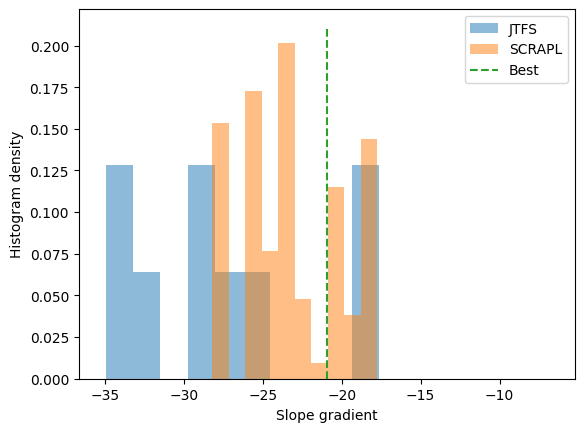

In [362]:
plt.hist(G_jtfs[:, 0].detach(), density=True, alpha=0.5, label='JTFS')
plt.hist(G_scrapl[:, 0].detach(), density=True,  alpha=0.5, label='SCRAPL')

y_coords = (4, 3)
Sx_best = load_jtfs(*x_coords, seed=0, data_dir=data_dir)[:, 0]
Jx_best = load_jacobian(*x_coords, seed=0, data_dir=data_dir)[:, 0]
G_best = (Jx_best.T @ (Sy - Sx_best)).detach()
plt.plot([G_best.item()]*2, [0, plt.gca().get_ylim()[1]], '--', label='Best')

half_width = torch.max(torch.abs(G_jtfs - G_best)).detach().numpy()
plt.xlim(G_best - 0.75*half_width, G_best + 0.75*half_width)
plt.legend()
plt.xlabel("Slope gradient")
plt.ylabel("Histogram density")

# Caution: does not work on every path